In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange
import mlplot

# Simple GAN using Keras

Source: [1D Generative Adversarial Network  in Keras](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/)

We select a simple **one-dimensional function** $f(x) = x^2$ as the basis for developing and evaluating a **generative adversarial network** from scratch using the Keras deep learning library:

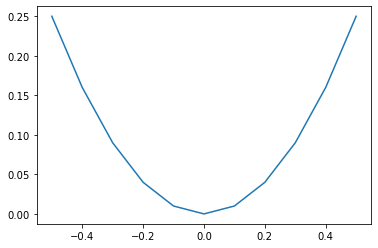

In [2]:
inputs = np.linspace(-0.5, 0.5, 11)
outputs = [(lambda x: x*x)(x) for x in inputs]

plt.plot(inputs, outputs);

We use this simple one-dimensional function because both real and generated samples can be plotted and **visually inspected** to get an idea of what has been learned. Also we don't require a sophisticated neural network models, hence the generator and discriminator models can be **easily understood**.

## Real and Fake Samples

The **real random samples** for the **discriminator model** are comprised of a **vector with two elements**, one for the input and one for the output of our one-dimensional function.

In [3]:
# generate n real samples with class labels '1'
def generate_real_samples(n):
    X1 = np.random.rand(n) - 0.5       # generate inputs in [-0.5, 0.5]
    X2 = X1 * X1                       # generate outputs X^2
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = np.hstack((X1, X2))
    y = np.ones((n, 1))                # generate class labels 'real'
    return X, y

# generate n fake samples with class labels '0'
def generate_fake_samples(n):
    X1 = -1 + np.random.rand(n) * 2    # generate inputs in [-1, 1]
    X2 = -1 + np.random.rand(n) * 2    # generate outputs in [-1, 1]
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = np.hstack((X1, X2))
    y = np.zeros((n, 1))               # generate class labels 'fake'
    return X, y

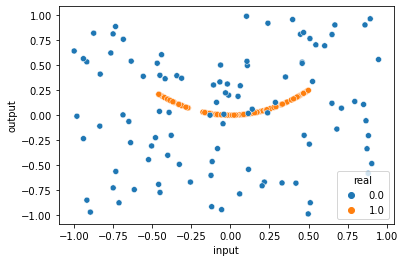

In [4]:
mlplot.plot_1d_samples(generate_real_samples, generate_fake_samples)

## Discriminator Model

The **discriminator** is a **binary classifier**.

The inputs are samples with two real values. The output is the likelihood that the sample is real (or fake).

The discriminator model will have **one hidden layer with 25 nodes** and we will use the **ReLU activation** function and an appropriate weight initialization method called **He weight initialization**.

The output layer will have one node for the binary classification using the **sigmoid** activation function.

The model will minimize the **binary cross entropy loss** function, and the **Adam** version of stochastic gradient descent will be used because it is very effective.

In [5]:
from keras.models import Sequential
from keras.layers import Dense

# define the standalone discriminator model
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

discriminator = define_discriminator()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                75        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


2021-12-06 14:10:23.508996: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Train the Discriminator Model

We can already train the discriminator, but there is no need to do this now. Doing this will be useful later and it helps to see that the **discriminator** is just a **normal neural network model**.

We generate for each epoch a **half batch of real** examples and a **half batch of fake** examples and update the model on one whole batch.

In [6]:
accs_real = []
accs_fake = []

def train_discriminator(model, n_epochs=1000, n_batch=128):
    half_batch = int(n_batch / 2)
    for epoch in trange(n_epochs):
        
        # train ond update weights of real data
        X_real, y_real = generate_real_samples(half_batch)
        model.train_on_batch(X_real, y_real)
        
        # train ond update weights of fake data
        X_fake, y_fake = generate_fake_samples(half_batch)
        model.train_on_batch(X_fake, y_fake)

        _, acc_real = model.evaluate(X_real, y_real, verbose=0)
        _, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
        accs_real.append(acc_real)
        accs_fake.append(acc_fake)

# train the model for 1.000 batches and using 128 samples per batch (64 fake and 64 real)
#train_discriminator(discriminator, n_epochs=100)

In [7]:
#mlplot.plot_discriminator_accuracy(accs_real, accs_fake)

## Generator Model

The goal is to **train a generator model**, not a discriminator model:

The generator model takes as **input** a point from the **latent space** and generates a new sample: a vector with both the input and output elements of our function.

A **latent variable** is a **hidden** or **unobserved variable**, and a **latent space** is a **multi-dimensional vector space** of these variables. We can define the size of the latent space for our problem and the shape or distribution of variables in the latent space.

This is because the latent space has no meaning until the generator model starts assigning meaning to points in the space as it learns. After training, points in the latent space will correspond to points in the output space, e.g. the space of generated samples.

We will define a small latent space of five dimensions and use the standard approach in the GAN literature of using a **Gaussian distribution** for each variable in the latent space. We will generate new inputs by drawing random numbers from a standard Gaussian distribution, i.e. mean of zero and a standard deviation of one.

* **Inputs**: Point in latent space, e.g. a five-element vector of Gaussian random numbers.
* **Outputs**: Two-element vector representing a generated sample for our function (x and x^2).

The generator model has a **single hidden layer** with five nodes and will use the **ReLU activation** function and the **He weight** initialization. The output layer will have two nodes for the two elements in a generated vector and will use a **linear activation function**.

A linear activation function is used because we know we want the generator to output a vector of real values and the scale will be `[-0.5, 0.5]` for the first element and about `[0.0, 0.25]` for the second element.

The **generator** model is **not trained** because it is **not fit directly**.

In [8]:
def generate_latent_points(latent_dim, n):
    x_input = np.random.randn(latent_dim * n)
    x_input = x_input.reshape(n, latent_dim)       # reshape into a batch of inputs for the network
    return x_input                                 # as input for the generator

def generate_fake_samples(generator, latent_dim, n):
    x_input = generate_latent_points(latent_dim, n)
    X = generator.predict(x_input)                 # predict outputs
    y = np.zeros((n, 1))                           # create class labels
    return X, y

In [9]:
from keras.models import Sequential
from keras.layers import Dense

def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

# define the generator model with a latent space of five dimensions
latent_dim = 5

generator = define_generator(latent_dim)
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 25)                150       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 52        
Total params: 202
Trainable params: 202
Non-trainable params: 0
_________________________________________________________________


We can see that the model takes as input a random five-element vector from the latent space and outputs a two-element vector for our one-dimensional function.

As the generator has not been trained, the generated points distributed noisy:

2021-12-06 14:10:23.678187: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


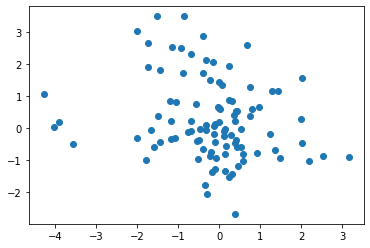

In [10]:
# plot fake samples
X, _ = generate_fake_samples(generator, latent_dim, 100)
plt.scatter(X[:, 0], X[:, 1]);

## Train the Generator Model

The weights in the generator model are updated by the discriminator model.

When the discriminator is good at detecting fake samples, the generator is updated more. When the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less. The generator model is only concerned with the discriminators performance on fake examples.

This defines the **zero-sum** or **adversarial** relationship between these two models.

### Composite GAN Model

We define a new composite GAN model that stacks the generator and discriminator such that the generator receives as input random points in the latent space, generates samples that are fed into the discriminator model directly, classified, and the output of this larger model can be used to update the model weights of the generator.

Here we want the discriminator to think that the samples output by the generator are real, not fake. Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real (class 1).

In [11]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    discriminator.trainable = False   # make weights in the discriminator not trainable
    model = Sequential()              # connect them
    model.add(generator)              # add generator
    model.add(discriminator)          # add the discriminator
    model.compile(loss='binary_crossentropy', optimizer='adam')   # compile model
    return model
 
# create the gan
gan = define_gan(generator, discriminator)
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 2)                 202       
_________________________________________________________________
sequential (Sequential)      (None, 1)                 101       
Total params: 303
Trainable params: 202
Non-trainable params: 101
_________________________________________________________________


In [12]:
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    x_real, y_real = generate_real_samples(n)                            # prepare real samples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)      # evaluate discriminator on real examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)     # prepare fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)      # evaluate discriminator on fake examples
    return mlplot.plot_1d_performance(epoch, acc_real, acc_fake, x_real, x_fake)

In [13]:
# train

n_epochs=10000
n_batch=128
half_batch = int(n_batch / 2)

# collect data for plot
images = []
accuracy_real = []
accuracy_fake = []

for epoch in trange(n_epochs):
    x_real, y_real = generate_real_samples(half_batch)                          # prepare real samples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)   # prepare fake examples
        
    # update discriminator
    discriminator.train_on_batch(x_real, y_real)
    discriminator.train_on_batch(x_fake, y_fake)

    x_gan = generate_latent_points(latent_dim, n_batch)                         # points in latent space as input for the generator
    y_gan = np.ones((n_batch, 1))                                               # inverted labels for the fake samples
        
    # update generator via the discriminators error
    gan.train_on_batch(x_gan, y_gan)

    # evaluate the model every 50 epochs
    if epoch % 50 == 0:
        #x_real, y_real = generate_real_samples(100)                            # prepare real samples
        _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)        # evaluate discriminator on real examples
        #x_fake, y_fake = generate_fake_samples(generator, latent_dim, 100)     # prepare fake examples
        _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)        # evaluate discriminator on fake examples
        accuracy_real.append(acc_real)
        accuracy_fake.append(acc_fake)
        fig = mlplot.plot_1d_performance(epoch, x_real, x_fake, accuracy_real, accuracy_fake)
        image = mlplot.fig2img(fig)
        images.append(image)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [15]:
from IPython.display import Image

images[0].save('images/simple_1d_gan.gif', save_all=True, append_images=images[1:], optimize=False, duration=80, loop=0)
#Image(filename='images/simple_1d_gan.gif')

![Plot Simple 1D GAN](images/simple_1d_gan.gif)